# Getting Started

Welcome to liionpack the battery pack simulation tool built using the PyBaMM battery mathematical modelling framework. This notebook will help you getting started.

First lets start off by importing the package as well as some other useful ones

In [1]:
import liionpack as lp
import pybamm
import numpy as np

c:\users\tom\code\pybamm\pybamm\expression_tree\functions.py:204: RuntimeWarning: invalid value encountered in sign
  return self.function(*evaluated_children)


We can create a pack definition in one of two ways: using an existing netlist or by specifying the number of batteries to connect in series and parallel.

Let's use the second option as it is the simplest using default parameters for resistances to define a 4p1s pack

In [2]:
I_mag = 5.0
OCV_init = 4.0 # used for intial guess
Ri_init = 5e-2 # used for intial guess
R_busbar = 1.5e-3
R_connection = 1e-2
Np = 4
Ns = 1
Nbatt = Np * Ns
netlist = lp.setup_circuit(Np=Np, Ns=Ns, Rb=R_busbar, Rc=R_connection, Ri=Ri_init, V=OCV_init, I=I_mag)

[The returned object is a pandas Dataframe containing description of the circuit elememt, the nodes in the circuit that they connect between and the initial value. For elements beginning with R the value is in [$\Omega$], for the batteries the open circuit voltage and an internal resistor are included and the value is in [V] and for the current source the value is in [A].

In [3]:
print(netlist)

    desc  node1  node2   value
0   Rbn0     13     14  0.0015
1   Rbn1     14     15  0.0015
2   Rbn2     15     16  0.0015
3   Rbn3     16     17  0.0015
4    Rs0      5      1  0.0100
5     V0      9      5  4.0000
6    Ri0     14      9  0.0500
7    Rs1      6      2  0.0100
8     V1     10      6  4.0000
9    Ri1     15     10  0.0500
10   Rs2      7      3  0.0100
11    V2     11      7  4.0000
12   Ri2     16     11  0.0500
13   Rs3      8      4  0.0100
14    V3     12      8  4.0000
15   Ri3     17     12  0.0500
16  Rbp4      1      0  0.0015
17  Rbp5      2      1  0.0015
18  Rbp6      3      2  0.0015
19  Rbp7      4      3  0.0015
20    I0      0     13  5.0000


This is the simplest pack we can have which is just one battery connected in series with two busbars and some extra resistors representing the connections to busbars and the internal resistance

We can view the circuit with a helper function

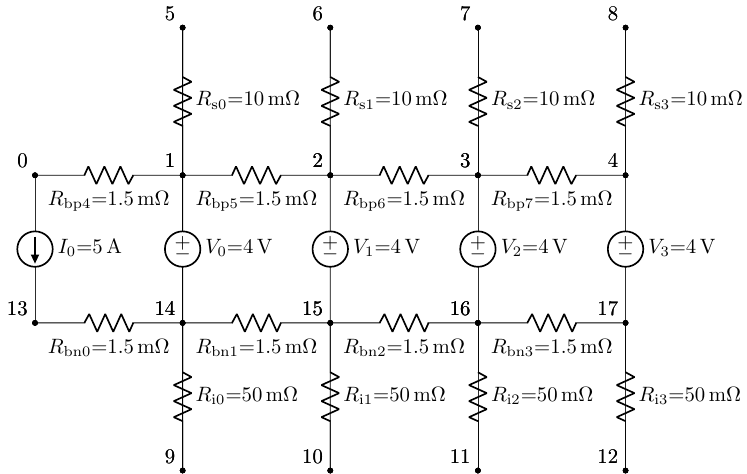

In [4]:
lp.draw_circuit(netlist, scale_factor=0.5, cpt_size=1.0, dpi=150, node_spacing=2.5)

Now lets generate an experimental protocol to use for the pack simulation. This will be the applied terminal current for each time step.

In [5]:
experiment = pybamm.Experiment(
    [f"Charge at {I_mag} A for 30 minutes",
     "Rest for 15 minutes",
     f"Discharge at {I_mag} A for 30 minutes",
     "Rest for 15 minutes"],
    period="10 seconds",
)
protocol = lp.generate_protocol_from_experiment(experiment)

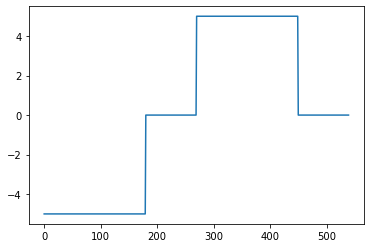

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(protocol)

Now we need to define the battery to be used in the simulation. This is done by using the PyBaMM ParameterValues class which is contructed using a parameter_set. We will use our favourite one which is the Chen2020 parameter set collected for the LG M50 21700 5Ah cell.

In [7]:
chemistry = pybamm.parameter_sets.Chen2020
parameter_values = pybamm.ParameterValues(chemistry=chemistry)

By default the simulation will output an array containing data for each time step and each battery. The default data that is included is the 'Terminal voltage [V]', 'Measured battery open circuit voltage [V]', 'Local ECM resistance [Ohm]'. However, we can also include additional variables to output from the models. The full list can be found associated with the SPMe model in PyBaMM.

In [8]:
SPMe = pybamm.models.full_battery_models.lithium_ion.SPMe()

c:\users\tom\code\pybamm\pybamm\expression_tree\functions.py:204: RuntimeWarning: invalid value encountered in sign
  return self.function(*evaluated_children)


In [9]:
for key in SPMe.variables.keys():
    print(key)

Time
Time [s]
Time [min]
Time [h]
x
x [m]
x_n
x_n [m]
x_s
x_s [m]
x_p
x_p [m]
Sum of electrolyte reaction source terms
Sum of negative electrode electrolyte reaction source terms
Sum of positive electrode electrolyte reaction source terms
Sum of x-averaged negative electrode electrolyte reaction source terms
Sum of x-averaged positive electrode electrolyte reaction source terms
Sum of interfacial current densities
Sum of negative electrode interfacial current densities
Sum of positive electrode interfacial current densities
Sum of x-averaged negative electrode interfacial current densities
Sum of x-averaged positive electrode interfacial current densities
r_p
r_p [m]
r_n
r_n [m]
Current density variable
Total current density
Total current density [A.m-2]
Current [A]
C-rate
Discharge capacity [A.h]
Porosity
Separator porosity
Positive electrode porosity
X-averaged separator porosity
X-averaged positive electrode porosity
Negative electrode porosity
X-averaged negative electrode porosity

Lets pick a few more interesting ones to output

In [10]:
output_variables = [  
    'X-averaged total heating [W.m-3]',
    'Volume-averaged cell temperature [K]',
    'X-averaged negative particle surface concentration [mol.m-3]',
    'X-averaged positive particle surface concentration [mol.m-3]',
    ]

As pack problems usually deal with Temperature we include have included the lumped temperature submodel by default and we have made the heat transfer coefficient an input to the pack model. This means that an individual heat transfer coefficienct must be supplied for each battery in the pack. All batteries use the same reference temperature. 

In [11]:
htc = np.ones(Nbatt) * 10

Ok now we're all set we can solve the pack problem

In [12]:
output = lp.solve(netlist=netlist,
                  parameter_values=parameter_values,
                  experiment=experiment,
                  output_variables=output_variables,
                  htc=htc)

Solving Pack: 100%|█████████████████████████████████████████████████████████████████| 540/540 [00:04<00:00, 110.17it/s]


We can now redraw the netlist to get the latest values for Open Circuit Voltage and internal resistance

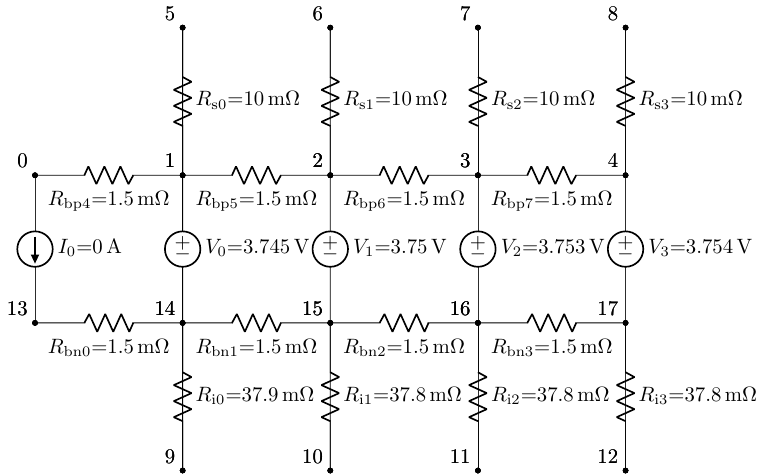

In [13]:
lp.draw_circuit(netlist, scale_factor=0.5, cpt_size=1.0, dpi=150, node_spacing=2.5)

Finally we can plot the simulation output

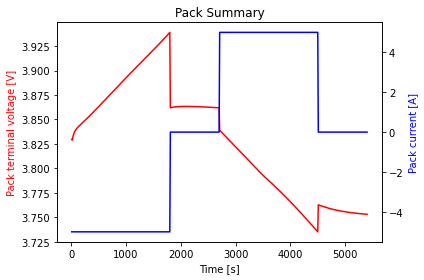

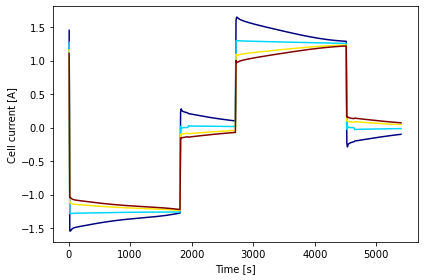

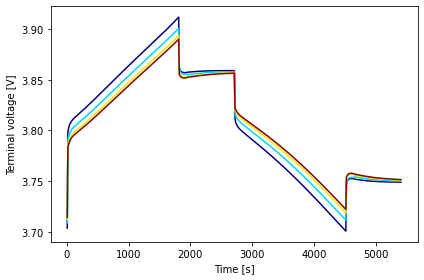

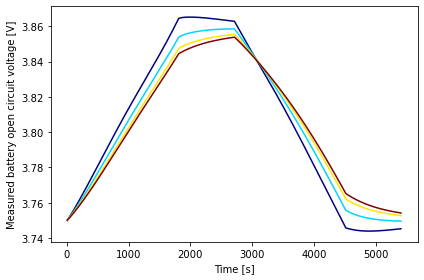

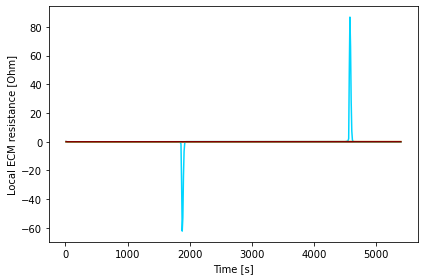

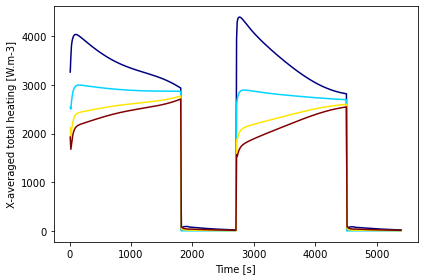

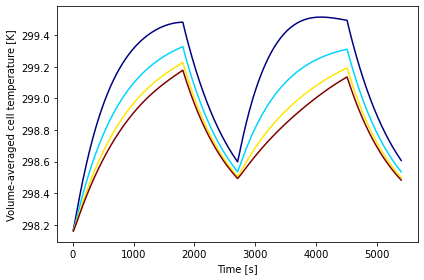

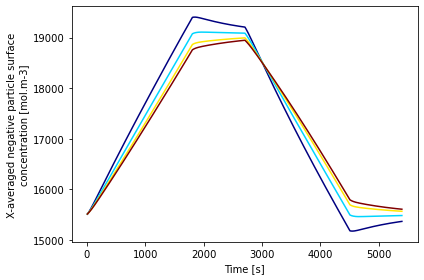

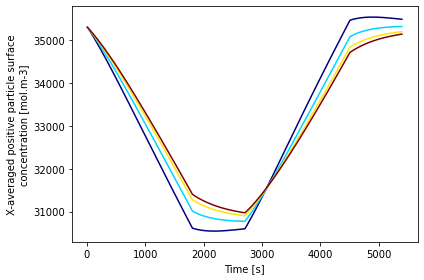

In [14]:
lp.plot_output(output)